In [6]:
from qiskit.circuit.library import UnitaryGate
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [5]:
from fable import fable

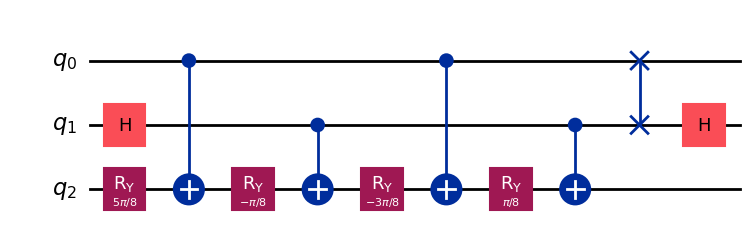

In [13]:
qc=QuantumCircuit(4)

def U_sin_matrix(x):
    return np.array([
        [np.cos(x),-np.sin(x)],
        [np.sin(x),np.cos(x)]
    ])
theta=np.pi/8
matrix=U_sin_matrix(theta)

U_sin,alpha=fable(matrix)
U_sin.draw("mpl")

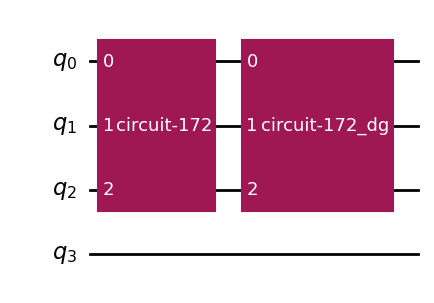

In [16]:
qc=QuantumCircuit(4)
qc.append(U_sin,qargs=[0,1,2])
qc.append(U_sin.inverse(),qargs=[0,1,2])
qc.draw(output="mpl")

In [17]:
theta = np.pi / 8  # Example angle
matrix = U_sin_matrix(theta)

# Create U_sin and its Fable encoding
U_sin, alpha = fable(matrix)  # Use Fable to generate the U_sin circuit
U_sin_dag = U_sin.inverse() 

In [ ]:
def qsp_layer(qc, qubits, ancilla, phi, d):
    """
    Constructs a single layer of QSP using the Fable-encoded U_sin.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit.
    - qubits (list[int]): List of indices for the qubits representing |x⟩n.
    - ancilla (int): The index for the ancilla qubit.
    - phi (float): The phase angle for the controlled phase gate.
    - d (int): The degree of polynomial approximation, determines parity behavior.
    """
    # Apply the Fable-encoded U_sin circuit
    qc.append(U_sin.to_instruction(label=r"$U_{sin} (\theta)$"), qubits)  # Use to_instruction() to add it as a single gate

    # Apply controlled-phase gate
    phase_matrix = np.array([[1, 0], [0, np.exp(-1j * phi)]])
    controlled_phase = UnitaryGate(phase_matrix, label=r"$e^{-\iota \phi_{'0'}} \sigma_{z}$")
    qc.append(controlled_phase.control(len(qubits)), qubits + [ancilla])
    
    qc.append(U_sin.inverse().to_instruction(label=r"$U_{Sin}^{\dag}(\theta)$"),qubits)

    qc.barrier()
   
    # Apply the inverse of U_sin if d is even
    if d % 2 != 0:
      qc.append(U_sin.to_instruction(label=r"$U_{sin} (\theta)$"), qubits)
      
      phi_d = phi # Modulo to avoid out-of-bounds access
      controlled_phase = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi_d)]]), label=r"$e^{-\iota \phi_{2}} \sigma_{z}$")

    # Ensure control qubits do not overlap with the ancilla qubit
      qc.cx(2,3)
      qc.append(controlled_phase, qargs=[3])
      qc.cx(3,2)

      qc.barrier()
    qc.h(3)
    qc.measure(3,0)


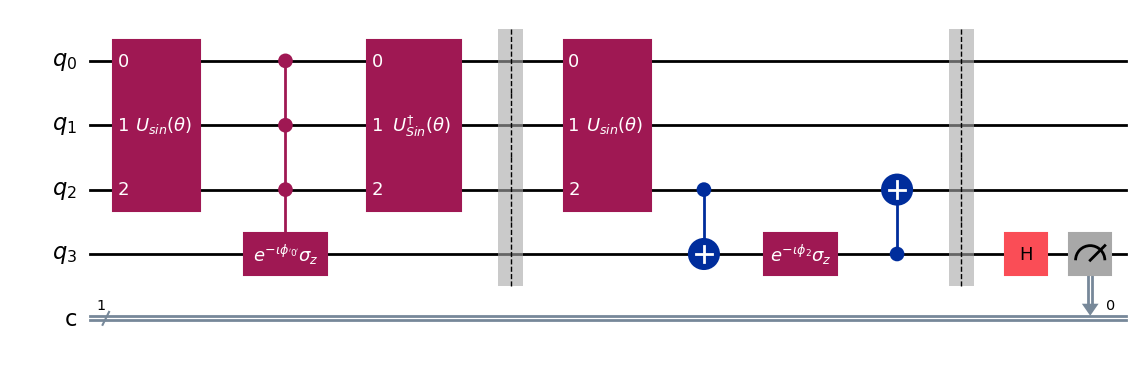

In [56]:
d = 3  # Set degree of polynomial approximation
phi = np.pi / 4  # Phase angle

# Initialize the main QSP circuit
qc = QuantumCircuit(4,1)  # 3 register qubits and 1 ancilla
register_qubits = [0, 1, 2]
ancilla_qubit = 3

# Apply a single QSP layer using the function
qsp_layer(qc, register_qubits, ancilla_qubit, phi, d)

# Draw the circuit
qc.draw(output="mpl")

In [94]:
def U_sqrt_matrix(x):
    return np.array([
        [np.sqrt(x), np.sqrt(1-x)],
        [np.sqrt(1-x), -np.sqrt(x)]
    ])

# Set theta and initialize U_sin matrix
theta = 0.25 # Example angle
matrix = U_sqrt_matrix(theta)

# Create U_sin and its Fable encoding with labels
U_sqrt, alpha = fable(matrix)
U_sqrt_instruction = U_sqrt.to_instruction(label=r"$U_{sqrt} (x)$")  # Labeled U_sin
U_sqrt_dag_instruction = U_sqrt.inverse().to_instruction(label=r"$U_{sqrt}^{\dag} (x)$") 

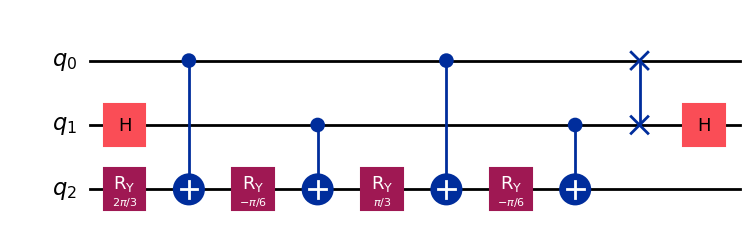

In [95]:
U_sin.draw("mpl")

In [96]:
def U_sin_matrix(x):
    x=np.deg2rad(x)
    return np.array([
        [np.cos(x), -np.sin(1-x)],
        [np.sin(1-x), np.cos(x)]
    ])
# Set theta and initialize U_sin matrix
theta = 0.25 # Example angle
matrix = U_sin_matrix(theta)

# Create U_sin and its Fable encoding with labels
U_sin, alpha = fable(matrix)
U_sin_instruction = U_sin.to_instruction(label=r"$U_{sin} (x)$")  # Labeled U_sin
U_sin_dag_instruction = U_sin.inverse().to_instruction(label=r"$U_{sin}^{\dag} (x)$") 

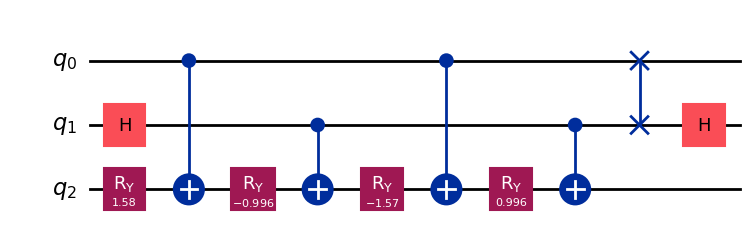

In [97]:
U_sin.draw(output="mpl")

In [85]:
def qsp_layer(qc, qubits, ancilla, phi):
    """
    Constructs a single layer of QSP using the Fable-encoded U_sin.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit.
    - qubits (list[int]): List of indices for the qubits representing |x⟩n.
    - ancilla (int): The index for the ancilla qubit.
    - phi (float): The phase angle for the controlled phase gate.
    """
    # Apply the Fable-encoded U_sin circuit
    qc.append(U_sin_instruction, qubits)

    # Apply controlled-phase gate
    phase_matrix = np.array([[1, 0], [0, np.exp(-1j * phi)]])
    controlled_phase = UnitaryGate(phase_matrix, label=r"$e^{-i \phi Z}$")
    qc.append(controlled_phase.control(len(qubits)), qubits + [ancilla])

    # Apply the inverse of U_sin
    qc.append(U_sin_dag_instruction, qubits)
    qc.barrier()

# Parameters
d = 3  # Set degree of polynomial approximation
phi = np.pi / 4  # Phase angle

# Initialize the main QSP circuit
qc = QuantumCircuit(4, 1)  # 3 register qubits and 1 ancilla
register_qubits = [0, 1, 2]
ancilla_qubit = 3

# Apply QSP layers according to degree d
for i in range(d):
    qsp_layer(qc, register_qubits, ancilla_qubit, phi)
    
    # Additional controlled phase gate if d is odd, only on the final layer
    if i == d - 1 and d % 2 != 0:
        qc.append(U_sin_instruction, register_qubits)
        controlled_phase_odd = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi)]]), label=r"$e^{-i \phi Z}$")
        qc.cx(register_qubits[-1], ancilla_qubit)  # Controlled-X between the last qubit and ancilla
        qc.append(controlled_phase_odd, [ancilla_qubit])
        qc.cx(register_qubits[-1], ancilla_qubit)
        qc.barrier()

# Final Hadamard and measurement on the ancilla qubit
qc.h(ancilla_qubit)
qc.measure(ancilla_qubit, 0)


In [86]:
from qiskit_aer import AerSimulator 
sim=AerSimulator()
depths_fable=[]
d_count=[]
t_count=[]

pm=generate_preset_pass_manager(backend=sim,optimization_level=3)


In [87]:
for i in range (2,11):
    d = i  # Set degree of polynomial approximation
    phi = np.pi / 4  # Phase angle

# Initialize the main QSP circuit
    qc = QuantumCircuit(4, 1)  # 3 register qubits and 1 ancilla
    register_qubits = [0, 1, 2]
    ancilla_qubit = 3

# Apply QSP layers according to degree d
    for  i in range(d):
      qsp_layer(qc, register_qubits, ancilla_qubit, phi)
    
    # Additional controlled phase gate if d is odd, only on the final layer
    if i == d - 1 and d % 2 != 0:
          qc.append(U_sin_instruction, register_qubits)
          controlled_phase_odd = UnitaryGate(np.array([[1, 0], [0, np.exp(-1j * phi)]]), label=r"$e^{-i \phi Z}$")
          qc.cx(register_qubits[-1], ancilla_qubit)  # Controlled-X between the last qubit and ancilla
          qc.append(controlled_phase_odd, [ancilla_qubit])
          qc.cx(register_qubits[-1], ancilla_qubit)
          qc.barrier()

# Final Hadamard and measurement on the ancilla qubit
    qc.h(ancilla_qubit)
    qc.measure(ancilla_qubit, 0)

    isa_circ=pm.run(qc)
    d_count.append(i)
    depths_fable.append(isa_circ.depth())


In [88]:
d_count

[1, 2, 3, 4, 5, 6, 7, 8, 9]

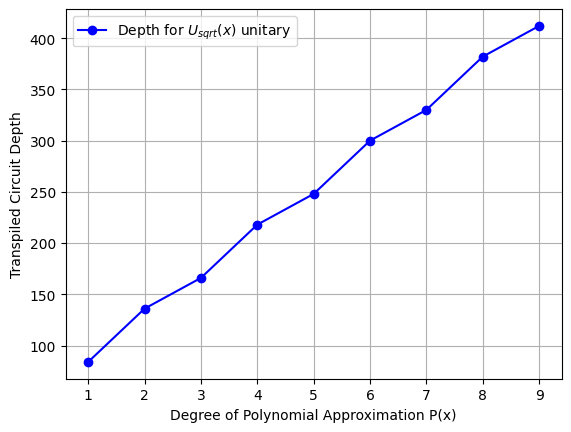

In [84]:
import matplotlib.pyplot as plt 

plt.plot(d_count,depths_fable,'bo-',label=r"Depth for $U_{sqrt}(x)$ unitary")
plt.grid(True)
plt.legend()
plt.xlabel("Degree of Polynomial Approximation P(x)")
plt.ylabel("Transpiled Circuit Depth")
plt.show()
